In [2]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
import statsmodels.api as sm

from datetime import timedelta

from sklearn.model_selection import TimeSeriesSplit

# Load and check data

In [3]:
PROCESSED_DATA_FOLDER = "data/4_all_data_preprocessed"
DATASET_FILE = "all_features"

In [4]:
# Load dataset
dataset = pickle.load(open(f"{PROCESSED_DATA_FOLDER}/{DATASET_FILE}.pkl", "rb"))

In [5]:
# Check the size of the data
dataset.shape

(192867, 760)

In [6]:
# Check preview the dataset
dataset.head()

event_indicator           city_resolvedAddress day_datetime  \
0            False  Луцьк, Луцький район, Україна   2022-02-25   
1            False  Луцьк, Луцький район, Україна   2022-02-25   
2            False  Луцьк, Луцький район, Україна   2022-02-25   
3            False  Луцьк, Луцький район, Україна   2022-02-25   
4            False  Луцьк, Луцький район, Україна   2022-02-25   

  isw_date_tomorrow_datetime  day_tempmax  day_tempmin  day_temp   day_dew  \
0                 2022-02-25    -0.914859    -0.891013 -1.005704 -0.859391   
1                 2022-02-25    -0.914859    -0.891013 -1.005704 -0.859391   
2                 2022-02-25    -0.914859    -0.891013 -1.005704 -0.859391   
3                 2022-02-25    -0.914859    -0.891013 -1.005704 -0.859391   
4                 2022-02-25    -0.914859    -0.891013 -1.005704 -0.859391   

   day_humidity  day_precip  ...  isw_work  isw_would  isw_wound  isw_year  \
0      0.463837   -0.150888  ... -0.572789  -0.900938  -0.484874 -0.454756   
1      0.463837   -0.150888  ... -0.572789  -0.900938  -0.484874 -0.454756   
2      0.463837   -0.150888  ... -0.572789  -0.900938  -0.484874 -0.454756   
3      0.463837   -0.150888  ... -0.572789  -0.900938  -0.484874 -0.454756   
4      0.463837   -0.150888  ... -0.572789  -0.900938  -0.484874 -0.454756   

    isw_yet  isw_yevgeni  isw_zaporizhia  isw_zaporizhzhia  isw_znpp  isw_zone  
0  6.697784    -0.370716       -1.173598         -0.536879 -0.464022 -0.456176  
1  6.697784    -0.370716       -1.173598         -0.536879 -0.464022 -0.456176  
2  6.697784    -0.370716       -1.173598         -0.536879 -0.464022 -0.456176  
3  6.697784    -0.370716       -1.173598         -0.536879 -0.464022 -0.456176  
4  6.697784    -0.370716       -1.173598         -0.536879 -0.464022 -0.456176  

[5 rows x 760 columns]

In [7]:
# Check summary of dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192867 entries, 0 to 192866
Columns: 760 entries, event_indicator to isw_zone
dtypes: bool(1), float64(756), object(3)
memory usage: 1.1+ GB


In [8]:
dataset.dtypes

event_indicator                  bool
city_resolvedAddress           object
day_datetime                   object
isw_date_tomorrow_datetime     object
day_tempmax                   float64
                               ...   
isw_yevgeni                   float64
isw_zaporizhia                float64
isw_zaporizhzhia              float64
isw_znpp                      float64
isw_zone                      float64
Length: 760, dtype: object

In [9]:
# Check nan
dataset.isna().sum()

event_indicator               0
city_resolvedAddress          0
day_datetime                  0
isw_date_tomorrow_datetime    0
day_tempmax                   0
                             ..
isw_yevgeni                   0
isw_zaporizhia                0
isw_zaporizhzhia              0
isw_znpp                      0
isw_zone                      0
Length: 760, dtype: int64

In [10]:
# Sort dataset by date
dataset['day_datetime'] = pd.to_datetime(dataset['day_datetime'])
dataset = dataset.sort_values(by='day_datetime')
dataset.day_datetime.describe(datetime_is_numeric=True)

count                           192867
mean     2022-08-02 23:32:38.163916288
min                2022-02-25 00:00:00
25%                2022-05-10 00:00:00
50%                2022-08-02 00:00:00
75%                2022-10-24 00:00:00
max                2023-01-20 00:00:00
Name: day_datetime, dtype: object

In [11]:
# Extract relevant date features
# dataset['year'] = dataset['day_datetime'].dt.year
# dataset['month'] = dataset['day_datetime'].dt.month
# dataset['day'] = dataset['day_datetime'].dt.day
dataset['day_of_week'] = dataset['day_datetime'].dt.dayofweek

# dataset['season'] = (dataset['day_datetime'].dt.month % 12 // 3).replace({0: 'winter', 1: 'spring', 2: 'summer', 3: 'fall'})

# dataset = pd.get_dummies(dataset, columns=['season'])

In [12]:
# Translate city names
dataset.rename(columns = {'city_resolvedAddress':'city'}, inplace=True)
dataset['city'].unique()

array(['Луцьк, Луцький район, Україна', 'Житомир, Україна',
       'Рівне, Україна', 'Полтава, Україна', 'Тернопіль, Україна',
       'Ужгород, Ужгородський район, Україна', 'Донецьк, Україна',
       'Запоріжжя, Україна', 'Суми, Україна', 'Черкаси, Україна',
       'Вінниця, Україна', 'Львів, Україна', 'Івано-Франківськ, Україна',
       'Херсон, Україна', 'Київ, Україна', 'Дніпро, Україна',
       'Чернівці, Україна', 'Кропивницький, Україна', 'Харків, Україна',
       'Миколаїв, Україна', 'Хмельницька область, Україна',
       'Одеса, Україна', 'Чернігів, Україна'], dtype=object)

In [13]:
region_dict = {
    "Київ, Україна" : 'Kyiv', 
    "Миколаїв, Україна" : 'Mykolaiv',
    "Дніпро, Україна": 'Dnipro',
    "Харків, Україна" : 'Kharkiv', 
    "Житомир, Україна": 'Zhytomyr',
    "Кропивницький, Україна": 'Kropyvnytskyi',
    "Запоріжжя, Україна": 'Zaporizhzhia',
    "Полтава, Україна": 'Poltava',
    "Чернігів, Україна": 'Chernihiv',
    "Одеса, Україна": 'Odesa',
    "Хмельницька область, Україна": 'Khmelnytskyi',
    "Черкаси, Україна": 'Cherkasy',
    "Суми, Україна": 'Sumy',
    "Вінниця, Україна": 'Vinnytsia',
    "Херсон, Україна": 'Kherson',
    "Львів, Україна": 'Lviv',
    "Луцьк, Луцький район, Україна": 'Lutsk',
    "Рівне, Україна": 'Rivne',
    "Івано-Франківськ, Україна": 'Ivano-Frankivsk',
    "Тернопіль, Україна": 'Ternopil',
    "Чернівці, Україна": 'Chernivtsi',
    "Ужгород, Ужгородський район, Україна": 'Uzhhorod',
    "Донецьк, Україна": 'Donetsk'
}

dataset = dataset.replace({"city": region_dict})

In [14]:
# Define target variable
dataset['target'] = dataset['event_indicator']
dataset = dataset.drop(columns=['event_indicator', 'isw_date_tomorrow_datetime'])

# check distribution of target column
dataset['target'] = dataset['target'].astype(int)
dataset['target'].value_counts()

0    143773
1     49094
Name: target, dtype: int64

In [15]:
# check the percentage distribution of target column
dataset['target'].value_counts()/(len(dataset))

0    0.745452
1    0.254548
Name: target, dtype: float64

[Text(0.5, 1.0, 'Countplot of events')]

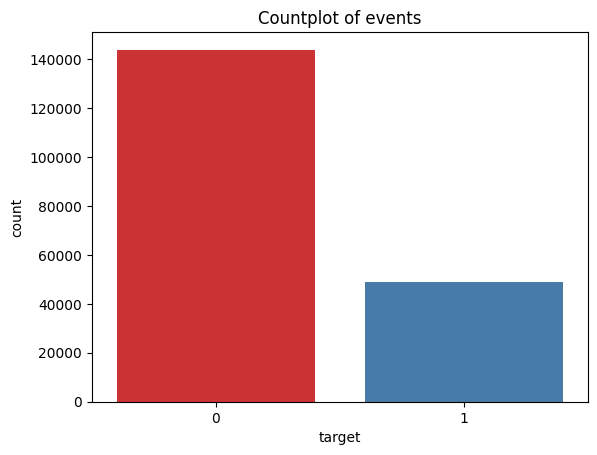

In [16]:
np.float = float
sns.countplot(x='target', data=dataset, palette='Set1').set(title = "Countplot of events")

Text(0, 0.5, 'Number of Air alerts')

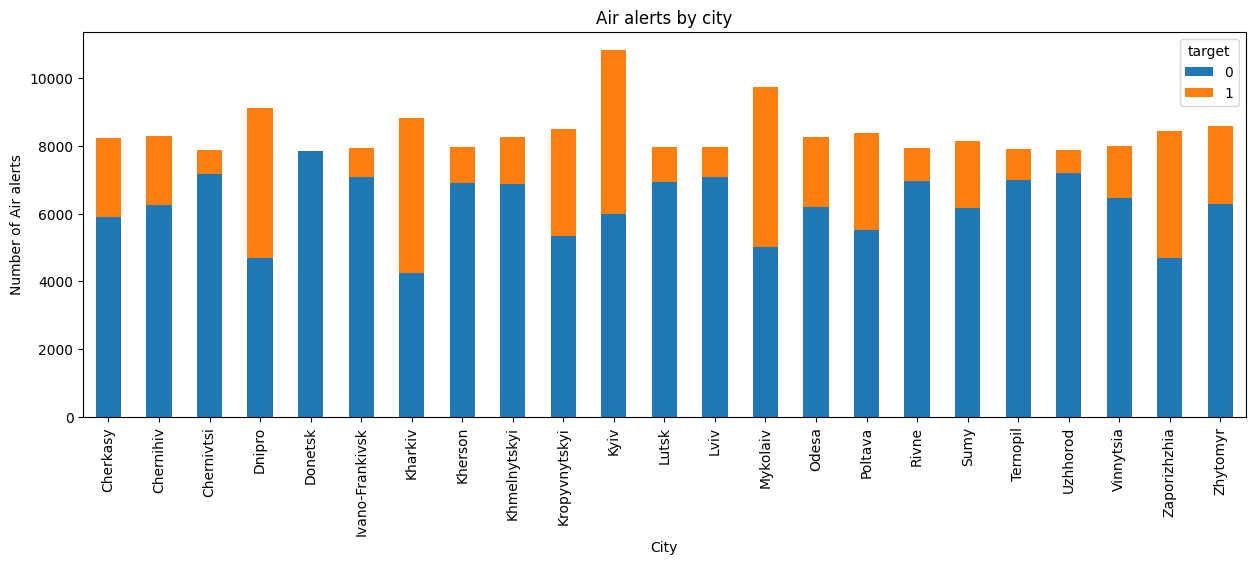

In [17]:
#%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 5]
pd.crosstab(dataset['city'], dataset['target']).plot(kind='bar', stacked=True)
plt.title('Air alerts by city')
plt.xlabel('City')
plt.ylabel('Number of Air alerts')

In [18]:
# Create id column for each unique city
# cities = dataset['city'].unique()
# city_dict = {cities[i]: i+1 for i in range(len(cities))}
# dataset['city_id'] = dataset['city'].map(city_dict)
dataset.drop('city', axis=1, inplace=True)

# Model Selection

In [19]:
models = {}

# Logistic Regression
# from sklearn.linear_model import LogisticRegression
# models['Logistic Regression'] = LogisticRegression(random_state=5, class_weight="balanced", verbose=True)

# Support Vector Machines - Poor performance
# from sklearn.svm import SVC
# models['Support Vector Machines'] = SVC(random_state=5, class_weight="balanced", verbose=True)

# Stochastic Gradient Descent
# from sklearn.linear_model import SGDClassifier
# models['Stochastic Gradient Descent'] = SGDClassifier(random_state=5, class_weight="balanced", loss="log", verbose=True)

# Random Forest
# from sklearn.ensemble import RandomForestClassifier
# models['Random Forest'] = RandomForestClassifier(random_state=5, class_weight="balanced", verbose=True)

# AdaBoost
# from sklearn.ensemble import AdaBoostClassifier
# models['AdaBoost'] = AdaBoostClassifier(random_state=5)


# XGBoost
from xgboost import XGBClassifier
models['XGBoost'] = XGBClassifier(random_state=5, objective='binary:logistic', booster='gbtree', verbose=2)

# k-Nearest Neighbors
# from sklearn.neighbors import KNeighborsClassifier
# models['KNN'] = KNeighborsClassifier(n_neighbors=7)

In [20]:
models

{'XGBoost': XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=5, ...)}

In [21]:
# Save the models to disk
for model_name in models.keys():
    filename = f'model/6__{model_name}__v0.pkl'
    pickle.dump(models[model_name], open(filename, 'wb'))
    print(f"{filename} saved")

model/6__XGBoost__v0.pkl saved


# Model Training

In [22]:
min_date = dataset['day_datetime'].min()
max_date = dataset['day_datetime'].max()
print("Min:", min_date, "Max:", max_date)

Min: 2022-02-25 00:00:00 Max: 2023-01-20 00:00:00


In [23]:
train_percent = .75
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between
train_cutoff

Timestamp('2022-10-29 18:00:00')

In [24]:
train_df = dataset[dataset['day_datetime'] <= train_cutoff]
test_df = dataset[dataset['day_datetime'] > train_cutoff]

In [25]:
# Split the dataset into features (X) and target (y)
X_train, X_test = train_df.drop(columns=['target', 'day_datetime']), test_df.drop(columns=['target', 'day_datetime'])
y_train, y_test = train_df['target'], test_df['target']

In [26]:
# Train models
predict_dict, predict_proba_dict = {}, {}

for key in models.keys():
    print(key)

    # Fit the classifier
    models[key].fit(X_train, y_train)

    # Make predictions
    predict_dict[key] = models[key].predict(X_test)
    predict_proba_dict[key] = models[key].predict_proba(X_test)[:, 1]

XGBoost
[21:35:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



# Model Evaluation

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import matthews_corrcoef
from scikitplot.helpers import binary_ks_curve

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [28]:
accuracy, precision, recall, f1, auc, pr_auc, loss, b_loss, ks_stat, matthews_corr = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}

for key in models.keys():
    
    # Calculate metrics
    accuracy[key] = accuracy_score(y_test, predict_dict[key])
    precision[key] = precision_score(y_test, predict_dict[key])
    recall[key] = recall_score(y_test, predict_dict[key])
    f1[key] = f1_score(y_test, predict_dict[key])
    auc[key] = roc_auc_score(y_test, predict_proba_dict[key])
    pr_auc[key] = average_precision_score(y_test, predict_proba_dict[key])
    loss[key] = log_loss(y_test, predict_proba_dict[key])
    b_loss[key] = brier_score_loss(y_test, predict_proba_dict[key])
    ks_stat[key] =  binary_ks_curve(y_test, predict_proba_dict[key])[3]
    matthews_corr[key] = matthews_corrcoef(y_test, predict_dict[key])
    
columns=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'PR AUC', 'Log loss', 'Brier score', 'KS', 'MCC']   
df_model = pd.DataFrame(index=models.keys(), columns=columns)

df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['F1'] = f1.values()
df_model['ROC AUC'] = auc.values()
df_model['PR AUC'] = pr_auc.values()
df_model['Log loss'] = loss.values()
df_model['Brier score'] = b_loss.values()
df_model['KS'] = ks_stat.values()
df_model['MCC'] = matthews_corr.values()

df_model

Accuracy  Precision    Recall        F1   ROC AUC    PR AUC  \
XGBoost  0.913168    0.74811  0.687127  0.716323  0.960248  0.775885   

         Log loss  Brier score        KS       MCC  
XGBoost  0.316417     0.074084  0.837423  0.666009

Confusion matrix for XGBoost


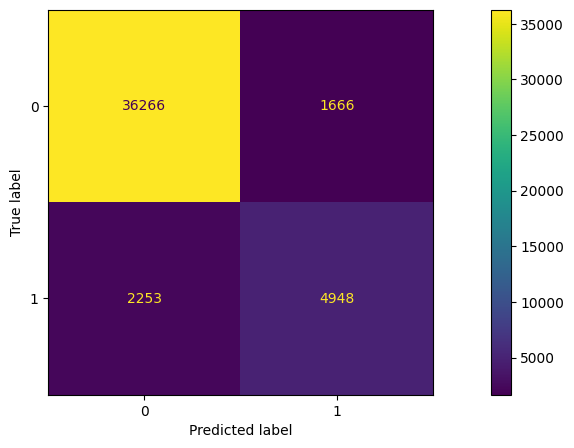

In [29]:
# Generate confusion matrix plots
for key in models.keys():
    print(f"Confusion matrix for {key}")
    
    matrix = confusion_matrix(y_test, predict_dict[key])
    cm = confusion_matrix(y_test, predict_dict[key], labels=models[key].classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=models[key].classes_)
    disp.plot()
    plt.show()

In [30]:
for key in models.keys():
    print(f"Classification report for {key}")
    print(classification_report(y_test, predict_dict[key]))
    print("=====================================================")

Classification report for XGBoost
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     37932
           1       0.75      0.69      0.72      7201

    accuracy                           0.91     45133
   macro avg       0.84      0.82      0.83     45133
weighted avg       0.91      0.91      0.91     45133



In [31]:
# ROC curves
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

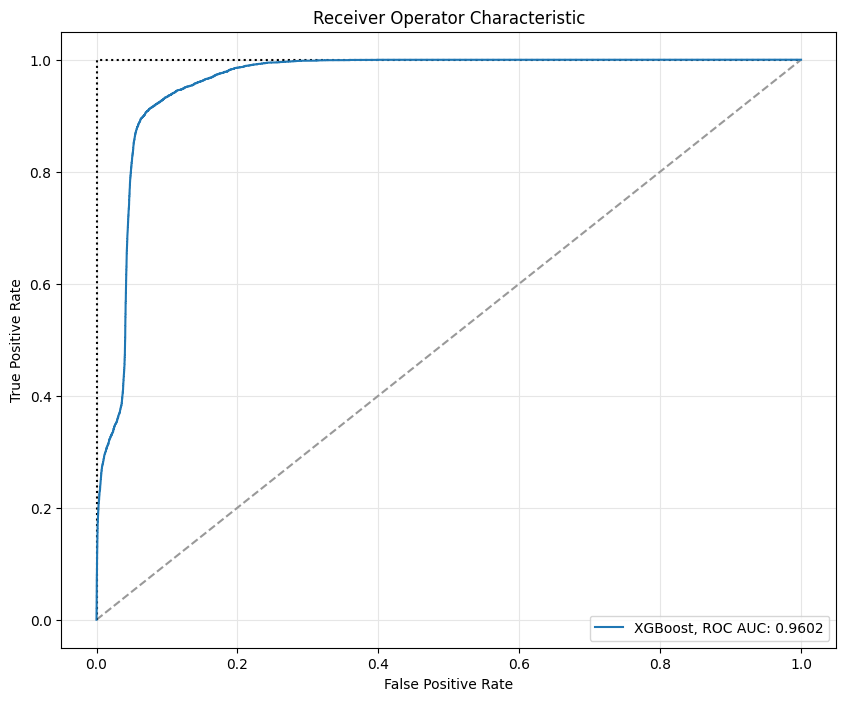

In [32]:
#set up plotting area
plt.rcParams["figure.figsize"] = [10, 8]
plt.figure(0).clf()

# roc curve for random and perfect models
plt.plot([0, 1], [0, 1], linestyle = '--', color = (0.6, 0.6, 0.6))
plt.plot([0, 0, 1], [0, 1, 1], linestyle = ':', color = 'black')

for key in models.keys():
    fpr, tpr, thresholds = roc_curve(y_test, predict_proba_dict[key])
    auc = round(roc_auc_score(y_test, predict_proba_dict[key]), 4)
    plt.plot(fpr, tpr, label=f"{key}, ROC AUC: {auc}")
 

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic')
plt.grid(color='0.9')
plt.legend()

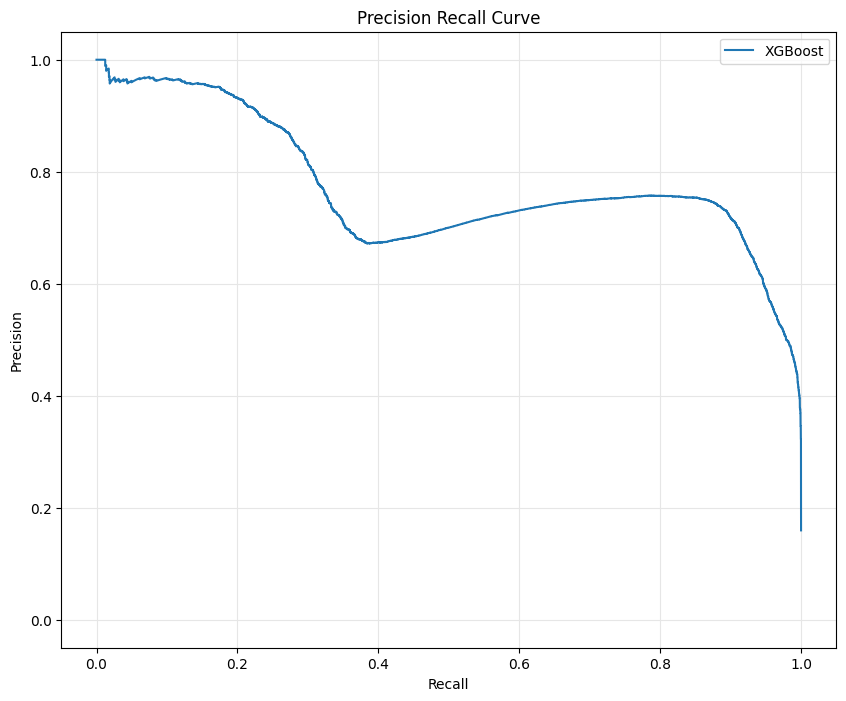

In [33]:
# Precision Recall Curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

#set up plotting area
plt.figure(0).clf()

for key in models.keys():
    precision, recall, thresholds = precision_recall_curve(y_test, predict_proba_dict[key])
    label = f'{key}'
    plt.plot(recall, precision, label = label)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')  
plt.ylabel('Precision')  
plt.title('Precision Recall Curve')
plt.grid(color='0.9')
plt.legend()

## Time-based cross-validation

In [34]:
from scipy import interp
from sklearn import metrics

from TimeBasedCV import *

In [35]:
tscv = TimeBasedCV(train_period=30, test_period=30)

In [36]:
for train_index, test_index in tscv.split(dataset, date_column='day_datetime'):
    print(train_index, test_index)

Train period: 2022-02-25 - 2022-03-27 , Test period 2022-03-27 - 2022-04-26 # train records 21315 , # test records 18141
Train period: 2022-03-27 - 2022-04-26 , Test period 2022-04-26 - 2022-05-26 # train records 18141 , # test records 17677
Train period: 2022-04-26 - 2022-05-26 , Test period 2022-05-26 - 2022-06-25 # train records 17677 , # test records 17307
Train period: 2022-05-26 - 2022-06-25 , Test period 2022-06-25 - 2022-07-25 # train records 17307 , # test records 17214
Train period: 2022-06-25 - 2022-07-25 , Test period 2022-07-25 - 2022-08-24 # train records 17214 , # test records 17196
Train period: 2022-07-25 - 2022-08-24 , Test period 2022-08-24 - 2022-09-23 # train records 17196 , # test records 17452
Train period: 2022-08-24 - 2022-09-23 , Test period 2022-09-23 - 2022-10-23 # train records 17452 , # test records 17382
Train period: 2022-09-23 - 2022-10-23 , Test period 2022-10-23 - 2022-11-22 # train records 17382 , # test records 17053
Train period: 2022-10-23 - 2022-

In [37]:
# get number of splits
tscv.get_n_splits()

9

In [38]:
selected_models = ['Logistic Regression', 'Random Forest', 'XGBoost']

In [39]:
X = dataset.drop(columns=['target'])
y = dataset['target']

### Logistic Regression

Train period: 2022-02-25 - 2022-03-27 , Test period 2022-03-27 - 2022-04-26 # train records 21315 , # test records 18141
Train period: 2022-03-27 - 2022-04-26 , Test period 2022-04-26 - 2022-05-26 # train records 18141 , # test records 17677
Train period: 2022-04-26 - 2022-05-26 , Test period 2022-05-26 - 2022-06-25 # train records 17677 , # test records 17307
Train period: 2022-05-26 - 2022-06-25 , Test period 2022-06-25 - 2022-07-25 # train records 17307 , # test records 17214
Train period: 2022-06-25 - 2022-07-25 , Test period 2022-07-25 - 2022-08-24 # train records 17214 , # test records 17196
Train period: 2022-07-25 - 2022-08-24 , Test period 2022-08-24 - 2022-09-23 # train records 17196 , # test records 17452
Train period: 2022-08-24 - 2022-09-23 , Test period 2022-09-23 - 2022-10-23 # train records 17452 , # test records 17382
Train period: 2022-09-23 - 2022-10-23 , Test period 2022-10-23 - 2022-11-22 # train records 17382 , # test records 17053
Train period: 2022-10-23 - 2022-

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\Users\tmyro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished
C:\Users\tmyro\AppData\Local\Temp\ipykernel_872\64552909.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\Users\t

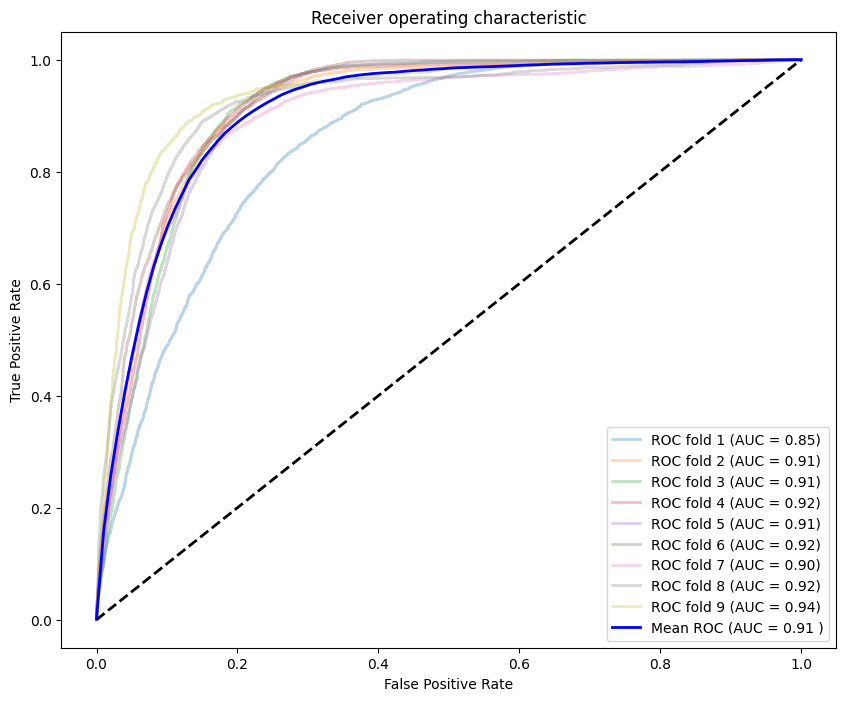

In [ ]:
#### Compute average test sets score (AUC)
mean_fpr = np.linspace(0, 1, 100)

tprs = []
aucs = []
i = 1
for train_index, test_index in tscv.split(X, date_column='day_datetime'):

    data_train   = X.loc[train_index].drop('day_datetime', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('day_datetime', axis=1)
    target_test  = y.loc[test_index]

    clf = models[selected_models[0]]
    clf.fit(data_train, target_train)

    probas_ = clf.predict_proba(data_test)[:, 1]
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(target_test, probas_)
    tprs.append(interp(mean_fpr, fpr, tpr))
    
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    i+=1

plt.plot([0,1], [0,1], linestyle = '--', lw = 2, color = 'black')

mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Random Forest

Train period: 2022-02-25 - 2022-03-27 , Test period 2022-03-27 - 2022-04-26 # train records 21315 , # test records 18141
Train period: 2022-03-27 - 2022-04-26 , Test period 2022-04-26 - 2022-05-26 # train records 18141 , # test records 17677
Train period: 2022-04-26 - 2022-05-26 , Test period 2022-05-26 - 2022-06-25 # train records 17677 , # test records 17307
Train period: 2022-05-26 - 2022-06-25 , Test period 2022-06-25 - 2022-07-25 # train records 17307 , # test records 17214
Train period: 2022-06-25 - 2022-07-25 , Test period 2022-07-25 - 2022-08-24 # train records 17214 , # test records 17196
Train period: 2022-07-25 - 2022-08-24 , Test period 2022-08-24 - 2022-09-23 # train records 17196 , # test records 17452
Train period: 2022-08-24 - 2022-09-23 , Test period 2022-09-23 - 2022-10-23 # train records 17452 , # test records 17382
Train period: 2022-09-23 - 2022-10-23 , Test period 2022-10-23 - 2022-11-22 # train records 17382 , # test records 17053
Train period: 2022-10-23 - 2022-

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
C:\Users\tmyro\AppData\Local\Temp\ipykernel_872\254256239.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
C:\Users\tmyro\AppData\Local\Temp\ipykernel_872\254256239.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.a

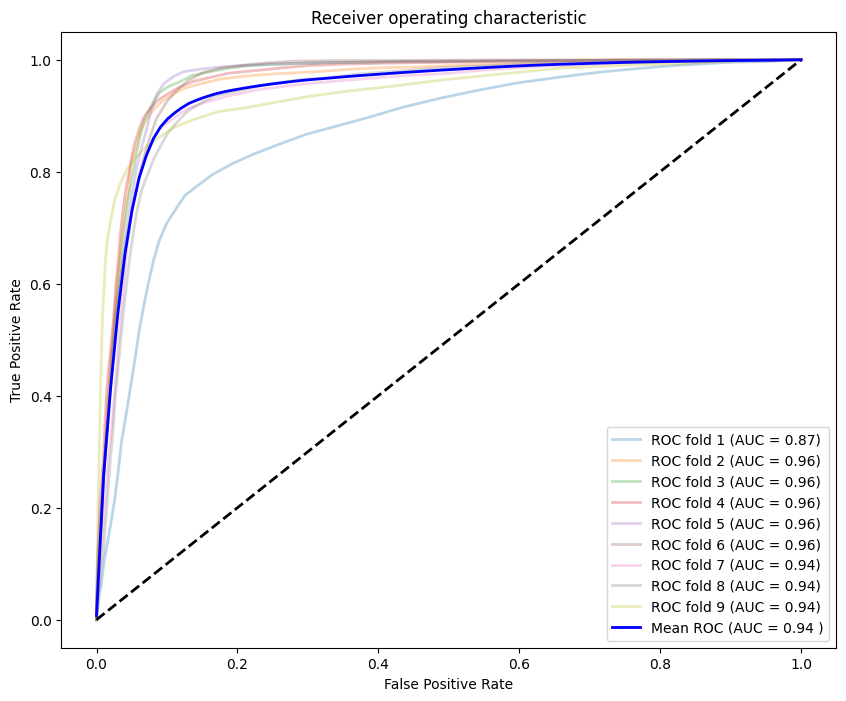

In [ ]:
#### Compute average test sets score (AUC)
mean_fpr = np.linspace(0, 1, 100)

tprs = []
aucs = []
i = 1
for train_index, test_index in tscv.split(X, date_column='day_datetime'):

    data_train   = X.loc[train_index].drop('day_datetime', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('day_datetime', axis=1)
    target_test  = y.loc[test_index]

    clf = models[selected_models[1]]
    clf.fit(data_train, target_train)

    probas_ = clf.predict_proba(data_test)[:, 1]
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(target_test, probas_)
    tprs.append(interp(mean_fpr, fpr, tpr))
    
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    i+=1

plt.plot([0,1], [0,1], linestyle = '--', lw = 2, color = 'black')

mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### XGBoost

Train period: 2022-02-25 - 2022-03-27 , Test period 2022-03-27 - 2022-04-26 # train records 21315 , # test records 18141
Train period: 2022-03-27 - 2022-04-26 , Test period 2022-04-26 - 2022-05-26 # train records 18141 , # test records 17677
Train period: 2022-04-26 - 2022-05-26 , Test period 2022-05-26 - 2022-06-25 # train records 17677 , # test records 17307
Train period: 2022-05-26 - 2022-06-25 , Test period 2022-06-25 - 2022-07-25 # train records 17307 , # test records 17214
Train period: 2022-06-25 - 2022-07-25 , Test period 2022-07-25 - 2022-08-24 # train records 17214 , # test records 17196
Train period: 2022-07-25 - 2022-08-24 , Test period 2022-08-24 - 2022-09-23 # train records 17196 , # test records 17452
Train period: 2022-08-24 - 2022-09-23 , Test period 2022-09-23 - 2022-10-23 # train records 17452 , # test records 17382
Train period: 2022-09-23 - 2022-10-23 , Test period 2022-10-23 - 2022-11-22 # train records 17382 , # test records 17053
Train period: 2022-10-23 - 2022-

C:\Users\tmyro\AppData\Local\Temp\ipykernel_3472\4015427900.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


[21:37:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



C:\Users\tmyro\AppData\Local\Temp\ipykernel_3472\4015427900.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


[21:38:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



C:\Users\tmyro\AppData\Local\Temp\ipykernel_3472\4015427900.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


[21:38:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



C:\Users\tmyro\AppData\Local\Temp\ipykernel_3472\4015427900.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


[21:38:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



C:\Users\tmyro\AppData\Local\Temp\ipykernel_3472\4015427900.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


[21:38:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



C:\Users\tmyro\AppData\Local\Temp\ipykernel_3472\4015427900.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


[21:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



C:\Users\tmyro\AppData\Local\Temp\ipykernel_3472\4015427900.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


[21:39:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



C:\Users\tmyro\AppData\Local\Temp\ipykernel_3472\4015427900.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


[21:39:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



C:\Users\tmyro\AppData\Local\Temp\ipykernel_3472\4015427900.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


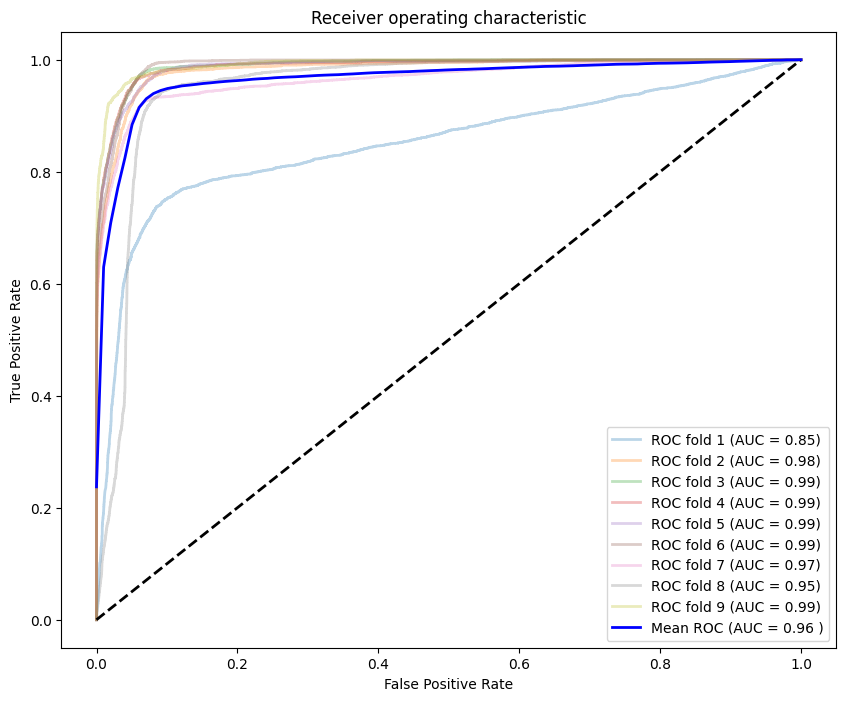

In [40]:
#### Compute average test sets score (AUC)
mean_fpr = np.linspace(0, 1, 100)

tprs = []
aucs = []
i = 1
for train_index, test_index in tscv.split(X, date_column='day_datetime'):

    data_train   = X.loc[train_index].drop('day_datetime', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('day_datetime', axis=1)
    target_test  = y.loc[test_index]

    clf = models[selected_models[2]]
    clf.fit(data_train, target_train)

    probas_ = clf.predict_proba(data_test)[:, 1]
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(target_test, probas_)
    tprs.append(interp(mean_fpr, fpr, tpr))
    
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    i+=1

plt.plot([0,1], [0,1], linestyle = '--', lw = 2, color = 'black')

mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Hyperparameter tuning

## Randomized grid search

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from random import randint, uniform

index_output = tscv.split(X, date_column='day_datetime')

Train period: 2022-02-25 - 2022-03-27 , Test period 2022-03-27 - 2022-04-26 # train records 21315 , # test records 18141
Train period: 2022-03-27 - 2022-04-26 , Test period 2022-04-26 - 2022-05-26 # train records 18141 , # test records 17677
Train period: 2022-04-26 - 2022-05-26 , Test period 2022-05-26 - 2022-06-25 # train records 17677 , # test records 17307
Train period: 2022-05-26 - 2022-06-25 , Test period 2022-06-25 - 2022-07-25 # train records 17307 , # test records 17214
Train period: 2022-06-25 - 2022-07-25 , Test period 2022-07-25 - 2022-08-24 # train records 17214 , # test records 17196
Train period: 2022-07-25 - 2022-08-24 , Test period 2022-08-24 - 2022-09-23 # train records 17196 , # test records 17452
Train period: 2022-08-24 - 2022-09-23 , Test period 2022-09-23 - 2022-10-23 # train records 17452 , # test records 17382
Train period: 2022-09-23 - 2022-10-23 , Test period 2022-10-23 - 2022-11-22 # train records 17382 , # test records 17053
Train period: 2022-10-23 - 2022-

In [42]:
params = {
 "learning_rate" : [0.1, 0.2, 0.3, 0.4],
 "max_depth" : [10, 12, 15],
 "min_child_weight" : [1, 3, 5, 7],
 "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
 "colsample_bytree" : [0.3, 0.5, 0.7]
}

In [43]:
xgb_clf = models['XGBoost']

In [44]:
model = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=params,
    n_iter=4,
    scoring='roc_auc',
    n_jobs=-1,
    refit=True,
    cv=index_output,
    verbose=3,
    pre_dispatch='2*n_jobs',
    random_state=5,
    return_train_score=True)

In [45]:
model.fit(X.drop('day_datetime', axis=1), y)
model.cv_results_

Fitting 9 folds for each of 4 candidates, totalling 36 fits
[21:48:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



{'mean_fit_time': array([ 67.81005022, 136.80506998,  76.45768415, 102.75368672]),
 'std_fit_time': array([ 5.67517518, 14.34619505,  7.8640623 , 22.68845263]),
 'mean_score_time': array([1.39767536, 1.0286732 , 1.09624206, 0.87433767]),
 'std_score_time': array([0.33615446, 0.19418819, 0.18579966, 0.38775504]),
 'param_min_child_weight': masked_array(data=[5, 3, 5, 1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[10, 12, 15, 12],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.2, 0.3, 0.2, 0.2],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.4, 0.4, 0.2, 0.3],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_colsample_bytree': masked_array(data=[0

In [46]:
print('\n All results:')
print(model.cv_results_)

print('\n Best estimator:')
print(model.best_estimator_)

print('\n Best hyperparameters:')
print(model.best_params_)

print("\n The best score across:")
print(model.best_score_)

results = pd.DataFrame(model.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([ 67.81005022, 136.80506998,  76.45768415, 102.75368672]), 'std_fit_time': array([ 5.67517518, 14.34619505,  7.8640623 , 22.68845263]), 'mean_score_time': array([1.39767536, 1.0286732 , 1.09624206, 0.87433767]), 'std_score_time': array([0.33615446, 0.19418819, 0.18579966, 0.38775504]), 'param_min_child_weight': masked_array(data=[5, 3, 5, 1],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[10, 12, 15, 12],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=[0.2, 0.3, 0.2, 0.2],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[0.4, 0.4, 0.2, 0.3],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_colsample_bytree': masked_array(data=[0.3, 0

In [47]:
#Building final classifier model
classifier = XGBClassifier(min_child_weight=1,
                           max_depth=12,
                           learning_rate=0.2,
                           gamma=0.3,
                           colsample_bytree=0.5,
                           objective='binary:logistic',
                           random_state=5, 
                           verbosity=3)

classifier.fit(X.drop('day_datetime', axis=1), y)

[21:51:58] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:157: Using tree method: 2
[21:52:01] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 1256 extra nodes, 34 pruned nodes, max_depth=12
[21:52:03] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 1284 extra nodes, 22 pruned nodes, max_depth=12
[21:52:04] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 1328 extra nodes, 34 pruned nodes, max_depth=12
[21:52:06] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tre

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=5, ...)

In [49]:
filename = f'model/6__XGBoost__v1.pkl'
pickle.dump(classifier, open(filename, 'wb'))
print(f"{filename} saved")

model/6__XGBoost__v1.pkl saved


## Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(classifier, X.drop('day_datetime', axis=1), y, cv=index_output, scoring="roc_auc", verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[10:43:19] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:157: Using tree method: 2
[10:43:20] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 484 extra nodes, 26 pruned nodes, max_depth=12
[10:43:20] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 380 extra nodes, 20 pruned nodes, max_depth=12
[10:43:20] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 380 extra nodes, 16 pruned nodes, max_depth=12
[10:43:20] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\u

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.1s remaining:    0.0s


[10:43:38] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:157: Using tree method: 2
[10:43:39] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 572 extra nodes, 10 pruned nodes, max_depth=12
[10:43:39] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 272 extra nodes, 6 pruned nodes, max_depth=12
[10:43:39] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 314 extra nodes, 18 pruned nodes, max_depth=12
[10:43:39] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\up

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.9s remaining:    0.0s


[10:43:54] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:157: Using tree method: 2
[10:43:55] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 508 extra nodes, 8 pruned nodes, max_depth=12
[10:43:55] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 280 extra nodes, 4 pruned nodes, max_depth=12
[10:43:55] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 324 extra nodes, 14 pruned nodes, max_depth=12
[10:43:55] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\upd

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.3min finished


In [ ]:
print("ROC AUC: %.2f%% (%.2f%%)" % (score.mean()*100, score.std()*100))

ROC AUC: 96.84% (3.89%)


## Cross Validation using XGBoost

In [ ]:
import xgboost as xgb

# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X.drop('day_datetime', axis=1), label=y)

In [ ]:
from xgboost import cv

params = {"objective":"binary:logistic",
          'min_child_weight': 1, 
          'max_depth': 12, 
          'learning_rate': 0.2, 
          'gamma': 0.3, 
          'colsample_bytree': 0.5}

xgb_cv = cv(dtrain=data_dmatrix, params=params, num_boost_round=50, folds=index_output,
            early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [ ]:
xgb_cv.head()

train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.993426       0.001882       0.941181      0.048084
1        0.996992       0.001356       0.931250      0.037727
2        0.998351       0.000915       0.936806      0.041957
3        0.998716       0.000832       0.940403      0.039752
4        0.999130       0.000620       0.946688      0.040031

In [ ]:
print('running cross validation, with preprocessing function')

# used to return the preprocessed training, test data, and parameter
# we can use this to do weight rescale, etc.
# as a example, we try to set scale_pos_weight
def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    ratio = float(np.sum(label == 0)) / np.sum(label == 1)
    param['scale_pos_weight'] = ratio
    return (dtrain, dtest, param)

xgb_cv = cv(dtrain=data_dmatrix, params=params, num_boost_round=50, folds=index_output,
            early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123, fpreproc=fpreproc)

running cross validation, with preprocessing function


In [ ]:
xgb_cv.head()

train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.995442       0.001085       0.939785      0.044611
1        0.997244       0.001195       0.928432      0.033544
2        0.998247       0.000859       0.932449      0.039004
3        0.998719       0.000726       0.932827      0.037456
4        0.999142       0.000627       0.939786      0.038473

## Feature importance

[0.00212885 0.00104302 0.00249574 0.00060276 0.00041901 0.00039092
 0.00044616 0.00057618 0.00039087 0.00035472 0.00109136 0.0019368
 0.00096846 0.00096669 0.00040696 0.00040819 0.00052743 0.00063308
 0.00042794 0.00020428 0.00086739 0.00040069 0.00045587 0.00036319
 0.00044982 0.00045192 0.0004962  0.00039347 0.0007297  0.0006947
 0.00051941 0.00043802 0.00037329 0.00071796 0.03592815 0.00183162
 0.02609945 0.00259429 0.00131222 0.00141237 0.00164888 0.00070597
 0.000486   0.00056946 0.00057948 0.00117651 0.0011588  0.0006755
 0.00086624 0.00064055 0.00089135 0.00069394 0.00082709 0.00108896
 0.00081464 0.00044358 0.00080651 0.0014675  0.00147529 0.00096207
 0.00080266 0.00862828 0.00054465 0.00114884 0.00073861 0.00324792
 0.00114529 0.00068281 0.00137581 0.00138789 0.00052075 0.00164292
 0.00068807 0.0016693  0.00106628 0.00052192 0.00061943 0.00101254
 0.00068177 0.00114274 0.00121214 0.00053755 0.00152157 0.00102286
 0.00232411 0.00081103 0.00045853 0.00071468 0.00084923 0.0020669

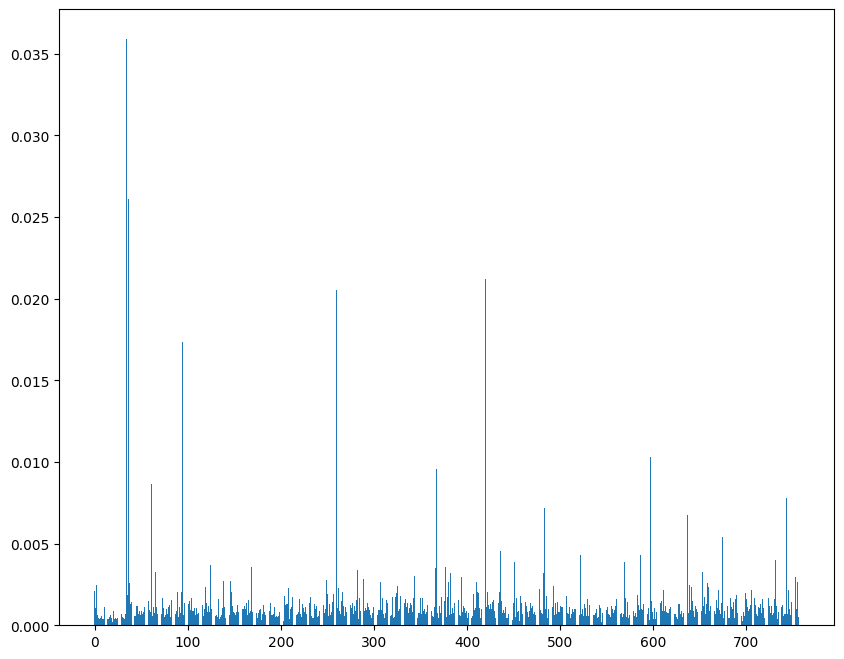

In [ ]:
# feature importance
print(classifier.feature_importances_)
# plot
pyplot.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
pyplot.show()

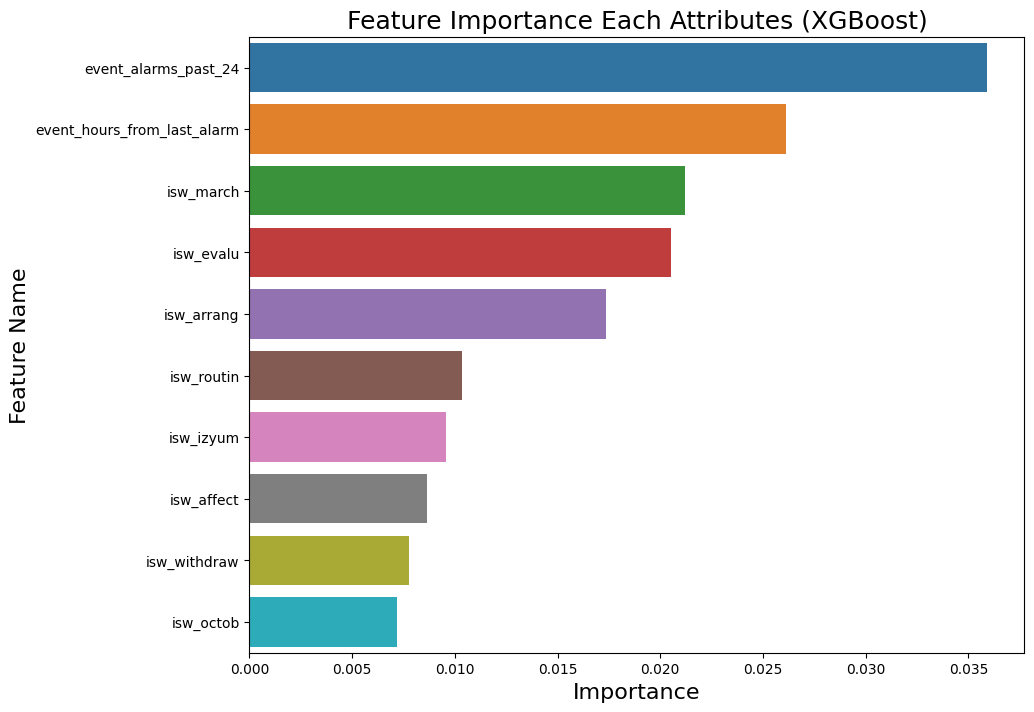

In [ ]:
imp_df = pd.DataFrame({
    "Feature Name": X.drop('day_datetime', axis=1).columns,
    "Importance": classifier.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Feature Importance Each Attributes (XGBoost)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


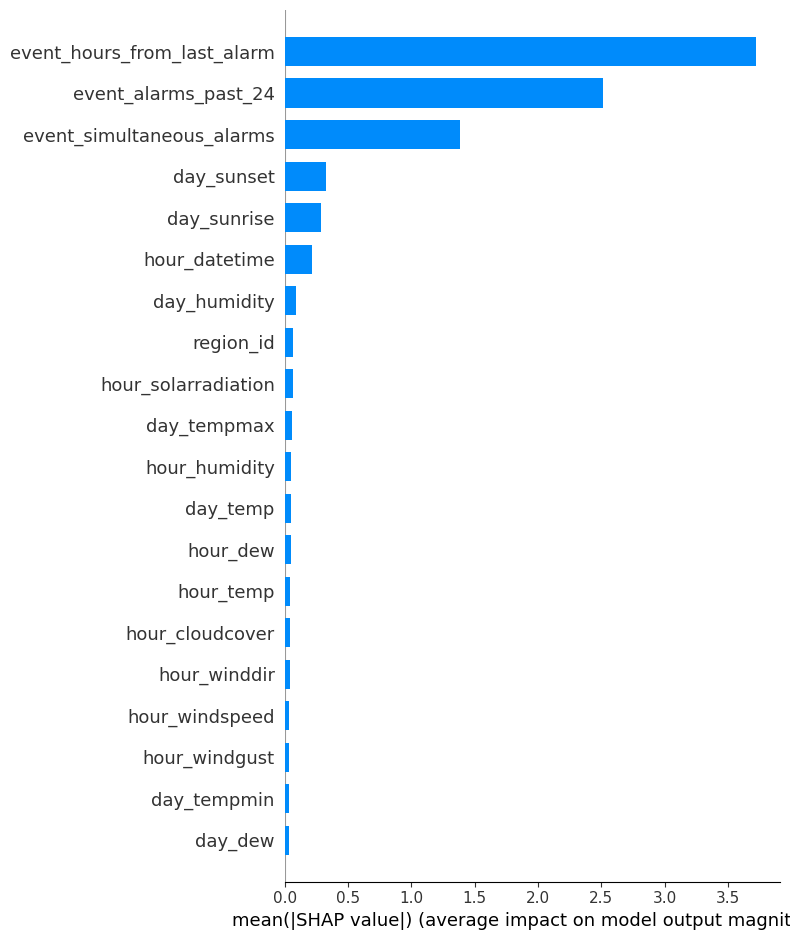

In [ ]:
import shap

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


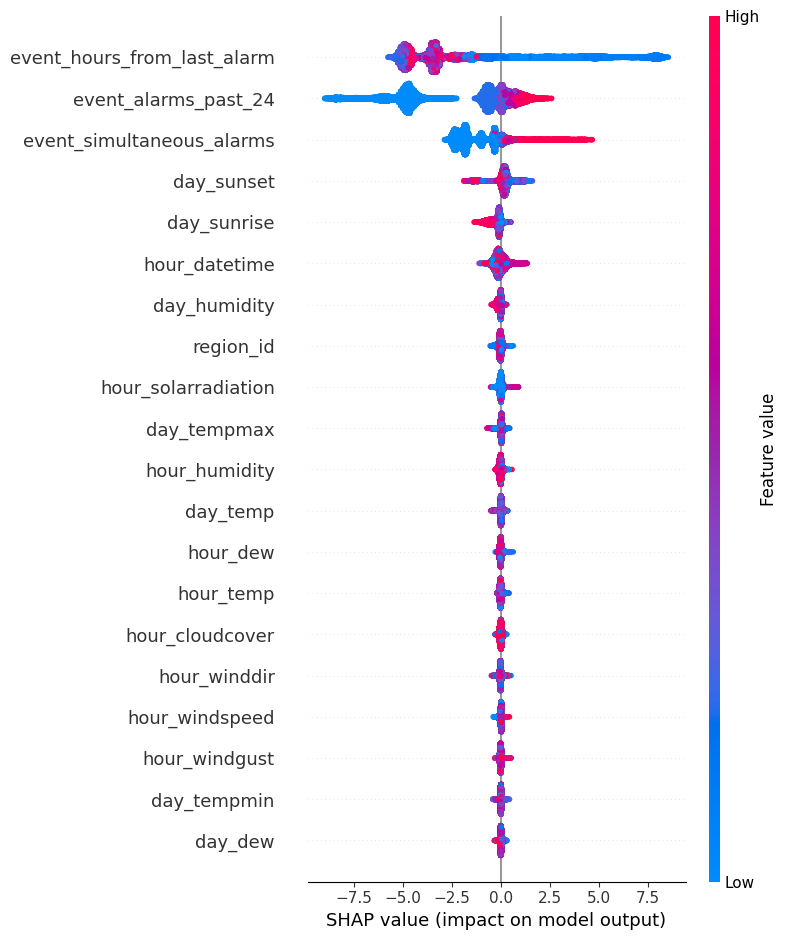

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.plots.waterfall(shap_values[0])

AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:day_datetime: datetime64[ns], isw_10km: Sparse[float64, 0], isw_12km: Sparse[float64, 0], isw_15km: Sparse[float64, 0], isw_1st: Sparse[float64, 0], isw_20km: Sparse[float64, 0], isw_30km: Sparse[float64, 0], isw_5km: Sparse[float64, 0], isw_6km: Sparse[float64, 0], isw_abandon: Sparse[float64, 0], isw_abil: Sparse[float64, 0], isw_abl: Sparse[float64, 0], isw_access: Sparse[float64, 0], isw_accus: Sparse[float64, 0], isw_achiev: Sparse[float64, 0], isw_across: Sparse[float64, 0], isw_action: Sparse[float64, 0], isw_activ: Sparse[float64, 0], isw_ad: Sparse[float64, 0], isw_addit: Sparse[float64, 0], isw_address: Sparse[float64, 0], isw_administr: Sparse[float64, 0], isw_advanc: Sparse[float64, 0], isw_advisor: Sparse[float64, 0], isw_affect: Sparse[float64, 0], isw_affili: Sparse[float64, 0], isw_aim: Sparse[float64, 0], isw_air: Sparse[float64, 0], isw_airborn: Sparse[float64, 0], isw_aircraft: Sparse[float64, 0], isw_airstrik: Sparse[float64, 0], isw_alexand: Sparse[float64, 0], isw_allow: Sparse[float64, 0], isw_almost: Sparse[float64, 0], isw_along: Sparse[float64, 0], isw_alongsid: Sparse[float64, 0], isw_alreadi: Sparse[float64, 0], isw_also: Sparse[float64, 0], isw_although: Sparse[float64, 0], isw_ammunit: Sparse[float64, 0], isw_among: Sparse[float64, 0], isw_amplifi: Sparse[float64, 0], isw_annex: Sparse[float64, 0], isw_announc: Sparse[float64, 0], isw_anoth: Sparse[float64, 0], isw_anti: Sparse[float64, 0], isw_appar: Sparse[float64, 0], isw_appeal: Sparse[float64, 0], isw_appear: Sparse[float64, 0], isw_appoint: Sparse[float64, 0], isw_approxim: Sparse[float64, 0], isw_april: Sparse[float64, 0], isw_area: Sparse[float64, 0], isw_arm: Sparse[float64, 0], isw_armi: Sparse[float64, 0], isw_armor: Sparse[float64, 0], isw_around: Sparse[float64, 0], isw_arrang: Sparse[float64, 0], isw_arriv: Sparse[float64, 0], isw_artilleri: Sparse[float64, 0], isw_assault: Sparse[float64, 0], isw_asset: Sparse[float64, 0], isw_attempt: Sparse[float64, 0], isw_author: Sparse[float64, 0], isw_avail: Sparse[float64, 0], isw_avdiivka: Sparse[float64, 0], isw_avoid: Sparse[float64, 0], isw_away: Sparse[float64, 0], isw_axi: Sparse[float64, 0], isw_back: Sparse[float64, 0], isw_bakhmut: Sparse[float64, 0], isw_bank: Sparse[float64, 0], isw_base: Sparse[float64, 0], isw_basi: Sparse[float64, 0], isw_battalion: Sparse[float64, 0], isw_battl: Sparse[float64, 0], isw_becom: Sparse[float64, 0], isw_began: Sparse[float64, 0], isw_begin: Sparse[float64, 0], isw_belaru: Sparse[float64, 0], isw_belarusian: Sparse[float64, 0], isw_belgorod: Sparse[float64, 0], isw_bilohorivka: Sparse[float64, 0], isw_blame: Sparse[float64, 0], isw_border: Sparse[float64, 0], isw_break: Sparse[float64, 0], isw_bridg: Sparse[float64, 0], isw_brigad: Sparse[float64, 0], isw_build: Sparse[float64, 0], isw_call: Sparse[float64, 0], isw_campaign: Sparse[float64, 0], isw_capabl: Sparse[float64, 0], isw_captur: Sparse[float64, 0], isw_carri: Sparse[float64, 0], isw_case: Sparse[float64, 0], isw_casualti: Sparse[float64, 0], isw_cauldron: Sparse[float64, 0], isw_caus: Sparse[float64, 0], isw_center: Sparse[float64, 0], isw_central: Sparse[float64, 0], isw_challeng: Sparse[float64, 0], isw_chang: Sparse[float64, 0], isw_channel: Sparse[float64, 0], isw_chechen: Sparse[float64, 0], isw_chief: Sparse[float64, 0], isw_child: Sparse[float64, 0], isw_choos: Sparse[float64, 0], isw_citizen: Sparse[float64, 0], isw_civilian: Sparse[float64, 0], isw_classifi: Sparse[float64, 0], isw_clear: Sparse[float64, 0], isw_click: Sparse[float64, 0], isw_close: Sparse[float64, 0], isw_colonel: Sparse[float64, 0], isw_combat: Sparse[float64, 0], isw_combin: Sparse[float64, 0], isw_come: Sparse[float64, 0], isw_command: Sparse[float64, 0], isw_comment: Sparse[float64, 0], isw_commerci: Sparse[float64, 0], isw_commit: Sparse[float64, 0], isw_commun: Sparse[float64, 0], isw_compani: Sparse[float64, 0], isw_complet: Sparse[float64, 0], isw_compris: Sparse[float64, 0], isw_concentr: Sparse[float64, 0], isw_concern: Sparse[float64, 0], isw_condemn: Sparse[float64, 0], isw_condit: Sparse[float64, 0], isw_confirm: Sparse[float64, 0], isw_conflict: Sparse[float64, 0], isw_connect: Sparse[float64, 0], isw_conscript: Sparse[float64, 0], isw_consid: Sparse[float64, 0], isw_consist: Sparse[float64, 0], isw_consolid: Sparse[float64, 0], isw_construct: Sparse[float64, 0], isw_contact: Sparse[float64, 0], isw_contract: Sparse[float64, 0], isw_control: Sparse[float64, 0], isw_convent: Sparse[float64, 0], isw_corp: Sparse[float64, 0], isw_could: Sparse[float64, 0], isw_council: Sparse[float64, 0], isw_counter: Sparse[float64, 0], isw_counterattack: Sparse[float64, 0], isw_counteroffens: Sparse[float64, 0], isw_countri: Sparse[float64, 0], isw_cours: Sparse[float64, 0], isw_cover: Sparse[float64, 0], isw_creat: Sparse[float64, 0], isw_crime: Sparse[float64, 0], isw_crimea: Sparse[float64, 0], isw_crimin: Sparse[float64, 0], isw_critic: Sparse[float64, 0], isw_cross: Sparse[float64, 0], isw_current: Sparse[float64, 0], isw_cut: Sparse[float64, 0], isw_daili: Sparse[float64, 0], isw_damag: Sparse[float64, 0], isw_data: Sparse[float64, 0], isw_date: Sparse[float64, 0], isw_day: Sparse[float64, 0], isw_decemb: Sparse[float64, 0], isw_decis: Sparse[float64, 0], isw_defend: Sparse[float64, 0], isw_defens: Sparse[float64, 0], isw_degrad: Sparse[float64, 0], isw_demand: Sparse[float64, 0], isw_demonstr: Sparse[float64, 0], isw_deni: Sparse[float64, 0], isw_deploy: Sparse[float64, 0], isw_depot: Sparse[float64, 0], isw_deputi: Sparse[float64, 0], isw_describ: Sparse[float64, 0], isw_despit: Sparse[float64, 0], isw_destroy: Sparse[float64, 0], isw_detail: Sparse[float64, 0], isw_develop: Sparse[float64, 0], isw_differ: Sparse[float64, 0], isw_direct: Sparse[float64, 0], isw_directli: Sparse[float64, 0], isw_director: Sparse[float64, 0], isw_discus: Sparse[float64, 0], isw_disrupt: Sparse[float64, 0], isw_district: Sparse[float64, 0], isw_divis: Sparse[float64, 0], isw_dmitri: Sparse[float64, 0], isw_dnipro: Sparse[float64, 0], isw_dnipropetrovsk: Sparse[float64, 0], isw_dnr: Sparse[float64, 0], isw_domest: Sparse[float64, 0], isw_donba: Sparse[float64, 0], isw_draw: Sparse[float64, 0], isw_drive: Sparse[float64, 0], isw_drone: Sparse[float64, 0], isw_due: Sparse[float64, 0], isw_duma: Sparse[float64, 0], isw_earli: Sparse[float64, 0], isw_east: Sparse[float64, 0], isw_eastern: Sparse[float64, 0], isw_econom: Sparse[float64, 0], isw_effect: Sparse[float64, 0], isw_eight: Sparse[float64, 0], isw_eighteen: Sparse[float64, 0], isw_eighti: Sparse[float64, 0], isw_either: Sparse[float64, 0], isw_element: Sparse[float64, 0], isw_eleven: Sparse[float64, 0], isw_emphas: Sparse[float64, 0], isw_encircl: Sparse[float64, 0], isw_end: Sparse[float64, 0], isw_endnot: Sparse[float64, 0], isw_energi: Sparse[float64, 0], isw_enerhodar: Sparse[float64, 0], isw_enforc: Sparse[float64, 0], isw_engag: Sparse[float64, 0], isw_enter: Sparse[float64, 0], isw_entir: Sparse[float64, 0], isw_entireti: Sparse[float64, 0], isw_equip: Sparse[float64, 0], isw_establish: Sparse[float64, 0], isw_evacu: Sparse[float64, 0], isw_evalu: Sparse[float64, 0], isw_even: Sparse[float64, 0], isw_evid: Sparse[float64, 0], isw_exist: Sparse[float64, 0], isw_expand: Sparse[float64, 0], isw_expect: Sparse[float64, 0], isw_explos: Sparse[float64, 0], isw_express: Sparse[float64, 0], isw_extens: Sparse[float64, 0], isw_face: Sparse[float64, 0], isw_facil: Sparse[float64, 0], isw_fail: Sparse[float64, 0], isw_failur: Sparse[float64, 0], isw_fall: Sparse[float64, 0], isw_fals: Sparse[float64, 0], isw_famili: Sparse[float64, 0], isw_far: Sparse[float64, 0], isw_februari: Sparse[float64, 0], isw_feder: Sparse[float64, 0], isw_fifteen: Sparse[float64, 0], isw_fifti: Sparse[float64, 0], isw_fight: Sparse[float64, 0], isw_fighter: Sparse[float64, 0], isw_financi: Sparse[float64, 0], isw_fire: Sparse[float64, 0], isw_first: Sparse[float64, 0], isw_five: Sparse[float64, 0], isw_focu: Sparse[float64, 0], isw_focus: Sparse[float64, 0], isw_follow: Sparse[float64, 0], isw_footag: Sparse[float64, 0], isw_forcibl: Sparse[float64, 0], isw_forecast: Sparse[float64, 0], isw_foreign: Sparse[float64, 0], isw_form: Sparse[float64, 0], isw_format: Sparse[float64, 0], isw_former: Sparse[float64, 0], isw_forti: Sparse[float64, 0], isw_fortif: Sparse[float64, 0], isw_four: Sparse[float64, 0], isw_fourteen: Sparse[float64, 0], isw_front: Sparse[float64, 0], isw_frontlin: Sparse[float64, 0], isw_full: Sparse[float64, 0], isw_fulli: Sparse[float64, 0], isw_futur: Sparse[float64, 0], isw_gain: Sparse[float64, 0], isw_geneva: Sparse[float64, 0], isw_geoloc: Sparse[float64, 0], isw_geospati: Sparse[float64, 0], isw_given: Sparse[float64, 0], isw_gloc: Sparse[float64, 0], isw_govern: Sparse[float64, 0], isw_governor: Sparse[float64, 0], isw_ground: Sparse[float64, 0], isw_group: Sparse[float64, 0], isw_grow: Sparse[float64, 0], isw_guard: Sparse[float64, 0], isw_gur: Sparse[float64, 0], isw_haidai: Sparse[float64, 0], isw_head: Sparse[float64, 0], isw_heavi: Sparse[float64, 0], isw_heavili: Sparse[float64, 0], isw_held: Sparse[float64, 0], isw_high: Sparse[float64, 0], isw_highli: Sparse[float64, 0], isw_highway: Sparse[float64, 0], isw_himar: Sparse[float64, 0], isw_hold: Sparse[float64, 0], isw_hope: Sparse[float64, 0], isw_hour: Sparse[float64, 0], isw_howev: Sparse[float64, 0], isw_hulyaipol: Sparse[float64, 0], isw_human: Sparse[float64, 0], isw_hundr: Sparse[float64, 0], isw_hundred: Sparse[float64, 0], isw_identifi: Sparse[float64, 0], isw_imageri: Sparse[float64, 0], isw_immedi: Sparse[float64, 0], isw_immin: Sparse[float64, 0], isw_import: Sparse[float64, 0], isw_improv: Sparse[float64, 0], isw_includ: Sparse[float64, 0], isw_increas: Sparse[float64, 0], isw_increasingli: Sparse[float64, 0], isw_independ: Sparse[float64, 0], isw_indic: Sparse[float64, 0], isw_individu: Sparse[float64, 0], isw_industri: Sparse[float64, 0], isw_infantri: Sparse[float64, 0], isw_inform: Sparse[float64, 0], isw_infrastructur: Sparse[float64, 0], isw_inhulet: Sparse[float64, 0], isw_initi: Sparse[float64, 0], isw_instead: Sparse[float64, 0], isw_institut: Sparse[float64, 0], isw_integr: Sparse[float64, 0], isw_intellig: Sparse[float64, 0], isw_intend: Sparse[float64, 0], isw_intensifi: Sparse[float64, 0], isw_interact: Sparse[float64, 0], isw_interdict: Sparse[float64, 0], isw_intern: Sparse[float64, 0], isw_invas: Sparse[float64, 0], isw_involv: Sparse[float64, 0], isw_issu: Sparse[float64, 0], isw_item: Sparse[float64, 0], isw_izyum: Sparse[float64, 0], isw_join: Sparse[float64, 0], isw_joint: Sparse[float64, 0], isw_juli: Sparse[float64, 0], isw_kakhovka: Sparse[float64, 0], isw_kharkiv: Sparse[float64, 0], isw_kill: Sparse[float64, 0], isw_kilomet: Sparse[float64, 0], isw_km: Sparse[float64, 0], isw_krai: Sparse[float64, 0], isw_kreminna: Sparse[float64, 0], isw_kremlin: Sparse[float64, 0], isw_kupyansk: Sparse[float64, 0], isw_kyiv: Sparse[float64, 0], isw_lack: Sparse[float64, 0], isw_land: Sparse[float64, 0], isw_larg: Sparse[float64, 0], isw_last: Sparse[float64, 0], isw_late: Sparse[float64, 0], isw_launch: Sparse[float64, 0], isw_law: Sparse[float64, 0], isw_le: Sparse[float64, 0], isw_lead: Sparse[float64, 0], isw_leader: Sparse[float64, 0], isw_leadership: Sparse[float64, 0], isw_least: Sparse[float64, 0], isw_leav: Sparse[float64, 0], isw_left: Sparse[float64, 0], isw_legal: Sparse[float64, 0], isw_level: Sparse[float64, 0], isw_liber: Sparse[float64, 0], isw_limit: Sparse[float64, 0], isw_line: Sparse[float64, 0], isw_lnr: Sparse[float64, 0], isw_local: Sparse[float64, 0], isw_locat: Sparse[float64, 0], isw_logist: Sparse[float64, 0], isw_long: Sparse[float64, 0], isw_longer: Sparse[float64, 0], isw_loss: Sparse[float64, 0], isw_lost: Sparse[float64, 0], isw_low: Sparse[float64, 0], isw_luhansk: Sparse[float64, 0], isw_lyman: Sparse[float64, 0], isw_lysychansk: Sparse[float64, 0], isw_made: Sparse[float64, 0], isw_main: Sparse[float64, 0], isw_maintain: Sparse[float64, 0], isw_major: Sparse[float64, 0], isw_make: Sparse[float64, 0], isw_mani: Sparse[float64, 0], isw_manpow: Sparse[float64, 0], isw_map: Sparse[float64, 0], isw_march: Sparse[float64, 0], isw_margin: Sparse[float64, 0], isw_marinka: Sparse[float64, 0], isw_mariupol: Sparse[float64, 0], isw_materi: Sparse[float64, 0], isw_may: Sparse[float64, 0], isw_mayor: Sparse[float64, 0], isw_mean: Sparse[float64, 0], isw_measur: Sparse[float64, 0], isw_mechan: Sparse[float64, 0], isw_medic: Sparse[float64, 0], isw_medium: Sparse[float64, 0], isw_meet: Sparse[float64, 0], isw_melitopol: Sparse[float64, 0], isw_member: Sparse[float64, 0], isw_men: Sparse[float64, 0], isw_milblogg: Sparse[float64, 0], isw_minist: Sparse[float64, 0], isw_ministri: Sparse[float64, 0], isw_missil: Sparse[float64, 0], isw_mobil: Sparse[float64, 0], isw_mod: Sparse[float64, 0], isw_month: Sparse[float64, 0], isw_moral: Sparse[float64, 0], isw_moscow: Sparse[float64, 0], isw_motor: Sparse[float64, 0], isw_move: Sparse[float64, 0], isw_movement: Sparse[float64, 0], isw_much: Sparse[float64, 0], isw_multipl: Sparse[float64, 0], isw_must: Sparse[float64, 0], isw_mykolaiv: Sparse[float64, 0], isw_nation: Sparse[float64, 0], isw_nationalist: Sparse[float64, 0], isw_naval: Sparse[float64, 0], isw_near: Sparse[float64, 0], isw_necessari: Sparse[float64, 0], isw_need: Sparse[float64, 0], isw_nevelsk: Sparse[float64, 0], isw_new: Sparse[float64, 0], isw_newli: Sparse[float64, 0], isw_news: Sparse[float64, 0], isw_next: Sparse[float64, 0], isw_nikopol: Sparse[float64, 0], isw_nine: Sparse[float64, 0], isw_no: Sparse[float64, 0], isw_north: Sparse[float64, 0], isw_northeast: Sparse[float64, 0], isw_northeastern: Sparse[float64, 0], isw_northern: Sparse[float64, 0], isw_northwest: Sparse[float64, 0], isw_northwestern: Sparse[float64, 0], isw_notabl: Sparse[float64, 0], isw_note: Sparse[float64, 0], isw_nova: Sparse[float64, 0], isw_novemb: Sparse[float64, 0], isw_nuclear: Sparse[float64, 0], isw_number: Sparse[float64, 0], isw_object: Sparse[float64, 0], isw_observ: Sparse[float64, 0], isw_occup: Sparse[float64, 0], isw_occupi: Sparse[float64, 0], isw_occur: Sparse[float64, 0], isw_octob: Sparse[float64, 0], isw_odesa: Sparse[float64, 0], isw_offens: Sparse[float64, 0], isw_offer: Sparse[float64, 0], isw_offic: Sparse[float64, 0], isw_offici: Sparse[float64, 0], isw_one: Sparse[float64, 0], isw_ongo: Sparse[float64, 0], isw_open: Sparse[float64, 0], isw_opposit: Sparse[float64, 0], isw_order: Sparse[float64, 0], isw_organ: Sparse[float64, 0], isw_outlet: Sparse[float64, 0], isw_outskirt: Sparse[float64, 0], isw_part: Sparse[float64, 0], isw_partial: Sparse[float64, 0], isw_particip: Sparse[float64, 0], isw_particularli: Sparse[float64, 0], isw_partisan: Sparse[float64, 0], isw_past: Sparse[float64, 0], isw_peopl: Sparse[float64, 0], isw_period: Sparse[float64, 0], isw_person: Sparse[float64, 0], isw_personnel: Sparse[float64, 0], isw_pervomaisk: Sparse[float64, 0], isw_petro: Sparse[float64, 0], isw_place: Sparse[float64, 0], isw_plan: Sparse[float64, 0], isw_plant: Sparse[float64, 0], isw_point: Sparse[float64, 0], isw_polit: Sparse[float64, 0], isw_poor: Sparse[float64, 0], isw_popul: Sparse[float64, 0], isw_posit: Sparse[float64, 0], isw_possibl: Sparse[float64, 0], isw_post: Sparse[float64, 0], isw_potenti: Sparse[float64, 0], isw_power: Sparse[float64, 0], isw_prepar: Sparse[float64, 0], isw_present: Sparse[float64, 0], isw_presid: Sparse[float64, 0], isw_press: Sparse[float64, 0], isw_pressur: Sparse[float64, 0], isw_prevent: Sparse[float64, 0], isw_previou: Sparse[float64, 0], isw_previous: Sparse[float64, 0], isw_prigozhin: Sparse[float64, 0], isw_primari: Sparse[float64, 0], isw_prior: Sparse[float64, 0], isw_priorit: Sparse[float64, 0], isw_prison: Sparse[float64, 0], isw_privat: Sparse[float64, 0], isw_pro: Sparse[float64, 0], isw_problem: Sparse[float64, 0], isw_process: Sparse[float64, 0], isw_produc: Sparse[float64, 0], isw_progress: Sparse[float64, 0], isw_promin: Sparse[float64, 0], isw_promis: Sparse[float64, 0], isw_protect: Sparse[float64, 0], isw_provid: Sparse[float64, 0], isw_provis: Sparse[float64, 0], isw_proxi: Sparse[float64, 0], isw_public: Sparse[float64, 0], isw_publicli: Sparse[float64, 0], isw_publish: Sparse[float64, 0], isw_push: Sparse[float64, 0], isw_putin: Sparse[float64, 0], isw_rang: Sparse[float64, 0], isw_rather: Sparse[float64, 0], isw_reach: Sparse[float64, 0], isw_readi: Sparse[float64, 0], isw_rear: Sparse[float64, 0], isw_receiv: Sparse[float64, 0], isw_recent: Sparse[float64, 0], isw_reconnaiss: Sparse[float64, 0], isw_recruit: Sparse[float64, 0], isw_redeploy: Sparse[float64, 0], isw_reduc: Sparse[float64, 0], isw_refer: Sparse[float64, 0], isw_refus: Sparse[float64, 0], isw_regain: Sparse[float64, 0], isw_regard: Sparse[float64, 0], isw_regiment: Sparse[float64, 0], isw_region: Sparse[float64, 0], isw_reinforc: Sparse[float64, 0], isw_reiter: Sparse[float64, 0], isw_rel: Sparse[float64, 0], isw_releas: Sparse[float64, 0], isw_remain: Sparse[float64, 0], isw_renew: Sparse[float64, 0], isw_repel: Sparse[float64, 0], isw_replac: Sparse[float64, 0], isw_reportedli: Sparse[float64, 0], isw_repres: Sparse[float64, 0], isw_republ: Sparse[float64, 0], isw_requir: Sparse[float64, 0], isw_reserv: Sparse[float64, 0], isw_resid: Sparse[float64, 0], isw_resist: Sparse[float64, 0], isw_respond: Sparse[float64, 0], isw_respons: Sparse[float64, 0], isw_restor: Sparse[float64, 0], isw_result: Sparse[float64, 0], isw_resum: Sparse[float64, 0], isw_retain: Sparse[float64, 0], isw_return: Sparse[float64, 0], isw_rifl: Sparse[float64, 0], isw_right: Sparse[float64, 0], isw_risk: Sparse[float64, 0], isw_river: Sparse[float64, 0], isw_road: Sparse[float64, 0], isw_rocket: Sparse[float64, 0], isw_role: Sparse[float64, 0], isw_routin: Sparse[float64, 0], isw_rubl: Sparse[float64, 0], isw_run: Sparse[float64, 0], isw_sabotag: Sparse[float64, 0], isw_said: Sparse[float64, 0], isw_satellit: Sparse[float64, 0], isw_scale: Sparse[float64, 0], isw_sea: Sparse[float64, 0], isw_second: Sparse[float64, 0], isw_section: Sparse[float64, 0], isw_secur: Sparse[float64, 0], isw_see: Sparse[float64, 0], isw_seek: Sparse[float64, 0], isw_seiz: Sparse[float64, 0], isw_send: Sparse[float64, 0], isw_separ: Sparse[float64, 0], isw_septemb: Sparse[float64, 0], isw_sergey: Sparse[float64, 0], isw_serhiy: Sparse[float64, 0], isw_serv: Sparse[float64, 0], isw_servic: Sparse[float64, 0], isw_serviceman: Sparse[float64, 0], isw_set: Sparse[float64, 0], isw_settlement: Sparse[float64, 0], isw_sever: Sparse[float64, 0], isw_severodonetsk: Sparse[float64, 0], isw_shell: Sparse[float64, 0], isw_shoigu: Sparse[float64, 0], isw_shortag: Sparse[float64, 0], isw_shot: Sparse[float64, 0], isw_show: Sparse[float64, 0], isw_sign: Sparse[float64, 0], isw_signific: Sparse[float64, 0], isw_similar: Sparse[float64, 0], isw_sinc: Sparse[float64, 0], isw_situat: Sparse[float64, 0], isw_siversk: Sparse[float64, 0], isw_six: Sparse[float64, 0], isw_sixteen: Sparse[float64, 0], isw_sixti: Sparse[float64, 0], isw_slovyansk: Sparse[float64, 0], isw_slow: Sparse[float64, 0], isw_small: Sparse[float64, 0], isw_social: Sparse[float64, 0], isw_sociocultur: Sparse[float64, 0], isw_soldier: Sparse[float64, 0], isw_soledar: Sparse[float64, 0], isw_soon: Sparse[float64, 0], isw_sourc: Sparse[float64, 0], isw_south: Sparse[float64, 0], isw_southeast: Sparse[float64, 0], isw_southern: Sparse[float64, 0], isw_southwest: Sparse[float64, 0], isw_southwestern: Sparse[float64, 0], isw_space: Sparse[float64, 0], isw_special: Sparse[float64, 0], isw_specif: Sparse[float64, 0], isw_spokesperson: Sparse[float64, 0], isw_staff: Sparse[float64, 0], isw_start: Sparse[float64, 0], isw_state: Sparse[float64, 0], isw_statement: Sparse[float64, 0], isw_static: Sparse[float64, 0], isw_station: Sparse[float64, 0], isw_still: Sparse[float64, 0], isw_stop: Sparse[float64, 0], isw_strateg: Sparse[float64, 0], isw_strengthen: Sparse[float64, 0], isw_strike: Sparse[float64, 0], isw_struck: Sparse[float64, 0], isw_structur: Sparse[float64, 0], isw_struggl: Sparse[float64, 0], isw_subject: Sparse[float64, 0], isw_subordin: Sparse[float64, 0], isw_success: Sparse[float64, 0], isw_suffer: Sparse[float64, 0], isw_suggest: Sparse[float64, 0], isw_sumi: Sparse[float64, 0], isw_suppli: Sparse[float64, 0], isw_surround: Sparse[float64, 0], isw_sustain: Sparse[float64, 0], isw_svatov: Sparse[float64, 0], isw_system: Sparse[float64, 0], isw_tactic: Sparse[float64, 0], isw_take: Sparse[float64, 0], isw_takeaway: Sparse[float64, 0], isw_taken: Sparse[float64, 0], isw_tank: Sparse[float64, 0], isw_target: Sparse[float64, 0], isw_telegram: Sparse[float64, 0], isw_ten: Sparse[float64, 0], isw_term: Sparse[float64, 0], isw_terrain: Sparse[float64, 0], isw_territori: Sparse[float64, 0], isw_thirteen: Sparse[float64, 0], isw_thirti: Sparse[float64, 0], isw_though: Sparse[float64, 0], isw_thousand: Sparse[float64, 0], isw_threat: Sparse[float64, 0], isw_threaten: Sparse[float64, 0], isw_three: Sparse[float64, 0], isw_throughout: Sparse[float64, 0], isw_thu: Sparse[float64, 0], isw_time: Sparse[float64, 0], isw_took: Sparse[float64, 0], isw_toward: Sparse[float64, 0], isw_train: Sparse[float64, 0], isw_transfer: Sparse[float64, 0], isw_transport: Sparse[float64, 0], isw_tri: Sparse[float64, 0], isw_troop: Sparse[float64, 0], isw_twelv: Sparse[float64, 0], isw_twenti: Sparse[float64, 0], isw_twenty: Sparse[float64, 0], isw_two: Sparse[float64, 0], isw_uk: Sparse[float64, 0], isw_unabl: Sparse[float64, 0], isw_unclear: Sparse[float64, 0], isw_unit: Sparse[float64, 0], isw_unlik: Sparse[float64, 0], isw_unspecifi: Sparse[float64, 0], isw_unsuccess: Sparse[float64, 0], isw_updat: Sparse[float64, 0], isw_urban: Sparse[float64, 0], isw_use: Sparse[float64, 0], isw_utterli: Sparse[float64, 0], isw_variou: Sparse[float64, 0], isw_vehicl: Sparse[float64, 0], isw_verifi: Sparse[float64, 0], isw_via: Sparse[float64, 0], isw_vicin: Sparse[float64, 0], isw_video: Sparse[float64, 0], isw_violat: Sparse[float64, 0], isw_vladimir: Sparse[float64, 0], isw_volunt: Sparse[float64, 0], isw_vuhledar: Sparse[float64, 0], isw_wagner: Sparse[float64, 0], isw_warn: Sparse[float64, 0], isw_wave: Sparse[float64, 0], isw_way: Sparse[float64, 0], isw_weapon: Sparse[float64, 0], isw_week: Sparse[float64, 0], isw_well: Sparse[float64, 0], isw_west: Sparse[float64, 0], isw_westward: Sparse[float64, 0], isw_whether: Sparse[float64, 0], isw_withdraw: Sparse[float64, 0], isw_within: Sparse[float64, 0], isw_without: Sparse[float64, 0], isw_work: Sparse[float64, 0], isw_would: Sparse[float64, 0], isw_wound: Sparse[float64, 0], isw_year: Sparse[float64, 0], isw_yet: Sparse[float64, 0], isw_yevgeni: Sparse[float64, 0], isw_zaporizhia: Sparse[float64, 0], isw_zaporizhzhia: Sparse[float64, 0], isw_znpp: Sparse[float64, 0], isw_zone: Sparse[float64, 0]

In [ ]:
# load JS visualization code to notebook
shap.initjs()

i = 30
shap.force_plot(explainer.expected_value, shap_values[i], features=X_test.iloc[i], feature_names=X_test.columns)

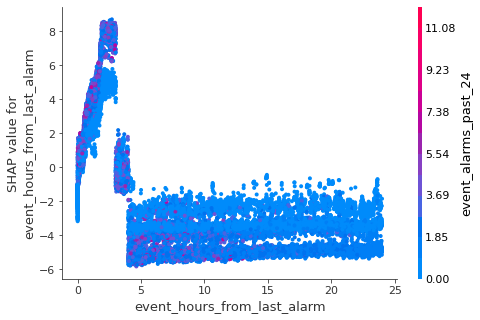

In [ ]:
shap.dependence_plot("event_hours_from_last_alarm", shap_values, X_test)